In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA, TruncatedSVD

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import  stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import warnings

In [2]:
# reading in and viewing results
check = pd.read_csv('data/results_dirty.csv')
check.head()

title  \
0                                  I’m a human, AMA.   
1                                   I've got Mormons   
2      Fuck it. Entropy can destroy a few universes.   
3  LPT: Humans are actually considered apex preda...   
4  Some random galactic empire managed to contact...   

                                            selftext  \
0                                          [removed]   
1  What do I do? They keep knocking on my door tr...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                                link  created_utc  is_fifth  
0  /r/fifthworldproblems/comments/ev9zkn/im_a_hum...   1580238813         1  
1  /r/fifthworldproblems/comments/ev9pzb/ive_got_...   1580237702         1  
2  /r/fifthworldproblems/comments/ev9cev/fuck_it_...   1580236112         1  
3  /r/fifthworldproblems/comments/ev8gl0/lpt_huma...   1580232375         1  
4  /r/fifthworldproblems/comments/ev4hai/some_ran...   1580211510         1

In [3]:
# checking for nulls
check.isna().sum()

title              1
selftext       12486
link               0
created_utc        0
is_fifth           0
dtype: int64

In [4]:
# checking class balance
check['is_fifth'].value_counts()

0    10500
1     9915
Name: is_fifth, dtype: int64

In [5]:
# removing nulls

check.dropna(inplace=True)

In [6]:
# removing removed or deleted posts

check = check[check['selftext'] != '[removed]']
check = check[check['selftext'] != '[deleted]']

In [7]:
# rechecking class balance
check['is_fifth'].value_counts()

1    5048
0    2307
Name: is_fifth, dtype: int64

In [8]:
# rebalancing classes
check = check[2741:]
check.reset_index(inplace=True, drop=True)
check['is_fifth'].value_counts()


1    2307
0    2307
Name: is_fifth, dtype: int64

In [9]:
# checking for duplicates
check.drop_duplicates()

title  \
0     Please help! This coded message keeps appearin...   
1     Help: I accidentally changed "a dime a dozen" ...   
2     My universal remote controller isn't controlli...   
3     Accidentally programmed a universe to rain nuk...   
4                    Help I accidentally did The Thing.   
...                                                 ...   
4609  My wife uses our shared calendar for personal ...   
4610    Can't find my car keys but the car still starts   
4611                        𝕴 𝖉𝖎𝖘𝖈𝖔𝖛𝖊𝖗𝖊𝖉 𝖘𝖔𝖒𝖊 𝖓𝖊𝖜 𝖋𝖔𝖓𝖙𝖘   
4612                                          Not again   
4613  I can't read the funny factoids on the Tropico...   

                                               selftext  \
0     e2 80 94 e2 80 94 e2 80 94 e2 80 94 e2 80 94 4...   
1                       No dimes for anyone. How does?    
2     Do you think I should try and get a refund, or...   
3     So, some context. I was hired for my extraordi...   
4     I accidentally did The Thing and I'm being att...   
...                                                 ...   
4609                            Grounds for divorce imo   
4610  Can't find my keys but they are in the car and...   
4611     𝔹𝕦𝕥 𝕕𝕠𝕟'𝕥 𝕜𝕟𝕠𝕨 𝕨𝕙𝕒𝕥 𝕤𝕦𝕓𝕣𝕖𝕕𝕕𝕚𝕥 𝕥𝕠 𝕡𝕠𝕤𝕥 𝕥𝕙𝕖𝕞 𝕚𝕟.   
4612  Do you ever go to gargle your mayonnaise but y...   
4613                I have to look them up somewhere...   

                                                   link  created_utc  is_fifth  
0     /r/fifthworldproblems/comments/av7zh9/please_h...   1551234603         1  
1     /r/fifthworldproblems/comments/av4gxg/help_i_a...   1551214653         1  
2     /r/fifthworldproblems/comments/av3ijh/my_unive...   1551209711         1  
3     /r/fifthworldproblems/comments/av3f0j/accident...   1551209231         1  
4     /r/fifthworldproblems/comments/av377t/help_i_a...   1551208123         1  
...                                                 ...          ...       ...  
4609  /r/firstworldproblems/comments/a7obv6/my_wife_...   1545239414         0  
4610  /r/firstworldproblems/comments/a7mx0j/cant_fin...   1545230040         0  
4611  /r/firstworldproblems/comments/a7hd10/𝕴_𝖉𝖎𝖘𝖈𝖔𝖛...   1545181099         0  
4612   /r/firstworldproblems/comments/a7h5fz/not_again/   1545179632         0  
4613  /r/firstworldproblems/comments/a7gjia/i_cant_r...   1545175463         0  

[4614 rows x 5 columns]

In [10]:
# removing utility columns
main = check.drop(columns=['created_utc', 'link'])

In [11]:
# combining title and selftext for later work tokenization
main['all_text'] = main['title'] + ' ' + main['selftext']
main.drop(columns=['selftext', 'title'], inplace=True)

In [12]:
# tokenizing words for visualization
main['all_text'] = [word_tokenize(val) for val in main['all_text']]

In [13]:
main['all_text']

0       [Please, help, !, This, coded, message, keeps,...
1       [Help, :, I, accidentally, changed, ``, a, dim...
2       [My, universal, remote, controller, is, n't, c...
3       [Accidentally, programmed, a, universe, to, ra...
4       [Help, I, accidentally, did, The, Thing, ., I,...
                              ...                        
4609    [My, wife, uses, our, shared, calendar, for, p...
4610    [Ca, n't, find, my, car, keys, but, the, car, ...
4611    [𝕴, 𝖉𝖎𝖘𝖈𝖔𝖛𝖊𝖗𝖊𝖉, 𝖘𝖔𝖒𝖊, 𝖓𝖊𝖜, 𝖋𝖔𝖓𝖙𝖘, 𝔹𝕦𝕥, 𝕕𝕠𝕟, ',...
4612    [Not, again, Do, you, ever, go, to, gargle, yo...
4613    [I, ca, n't, read, the, funny, factoids, on, t...
Name: all_text, Length: 4614, dtype: object

In [14]:
# removing stop words
main['all_text'] = [[i for i in val if i not in stopwords.words('english')] for val in main['all_text']]


In [15]:
main['all_text']

0       [Please, help, !, This, coded, message, keeps,...
1       [Help, :, I, accidentally, changed, ``, dime, ...
2       [My, universal, remote, controller, n't, contr...
3       [Accidentally, programmed, universe, rain, nuk...
4       [Help, I, accidentally, The, Thing, ., I, acci...
                              ...                        
4609    [My, wife, uses, shared, calendar, personal, r...
4610    [Ca, n't, find, car, keys, car, still, starts,...
4611    [𝕴, 𝖉𝖎𝖘𝖈𝖔𝖛𝖊𝖗𝖊𝖉, 𝖘𝖔𝖒𝖊, 𝖓𝖊𝖜, 𝖋𝖔𝖓𝖙𝖘, 𝔹𝕦𝕥, 𝕕𝕠𝕟, ',...
4612    [Not, Do, ever, go, gargle, mayonnaise, pick, ...
4613    [I, ca, n't, read, funny, factoids, Tropico, 5...
Name: all_text, Length: 4614, dtype: object

In [16]:
# lemmatizing text
lem = WordNetLemmatizer()

main['all_text'] = [[lem.lemmatize(i) for i in val] for val in main['all_text']]

In [17]:
# making bag of words for visualization
temp = []
[[temp.append(i) for i in val] for val in main['all_text']]
X = pd.DataFrame(temp)

In [18]:
# looking at the distribution of words

px.histogram(X,X[0].value_counts(), nbins=10000)


In [43]:
np.random.seed(4)
sample = np.random.choice(X[0], size=20000)

In [44]:
# preparing the bag of words for t-SNE 
cvec = CountVectorizer()
z = cvec.fit_transform(sample)


tsvd = TruncatedSVD(n_components=50)

z = tsvd.fit_transform(z)

In [45]:
# fitting and transformin t-SNE
# WARNING this cell takes a very long to run
w = z
tsne = TSNE(n_iter=500, angle=.5, perplexity=50, learning_rate=1000)

w = tsne.fit_transform(w)
w

array([[ 24.326422  ,   9.297369  ],
       [  5.9314623 , -21.303478  ],
       [  0.27699527,  19.594189  ],
       ...,
       [ -2.7251596 ,  33.99197   ],
       [ 40.776737  , -35.452583  ],
       [ 20.120838  , -19.881813  ]], dtype=float32)

In [46]:
X, w.shape

(                0
 0          Please
 1            help
 2               !
 3            This
 4           coded
 ...           ...
 223714          .
 223715          I
 223716       look
 223717  somewhere
 223718        ...
 
 [223719 rows x 1 columns], (20000, 2))

In [47]:
w[0,1]

9.297369

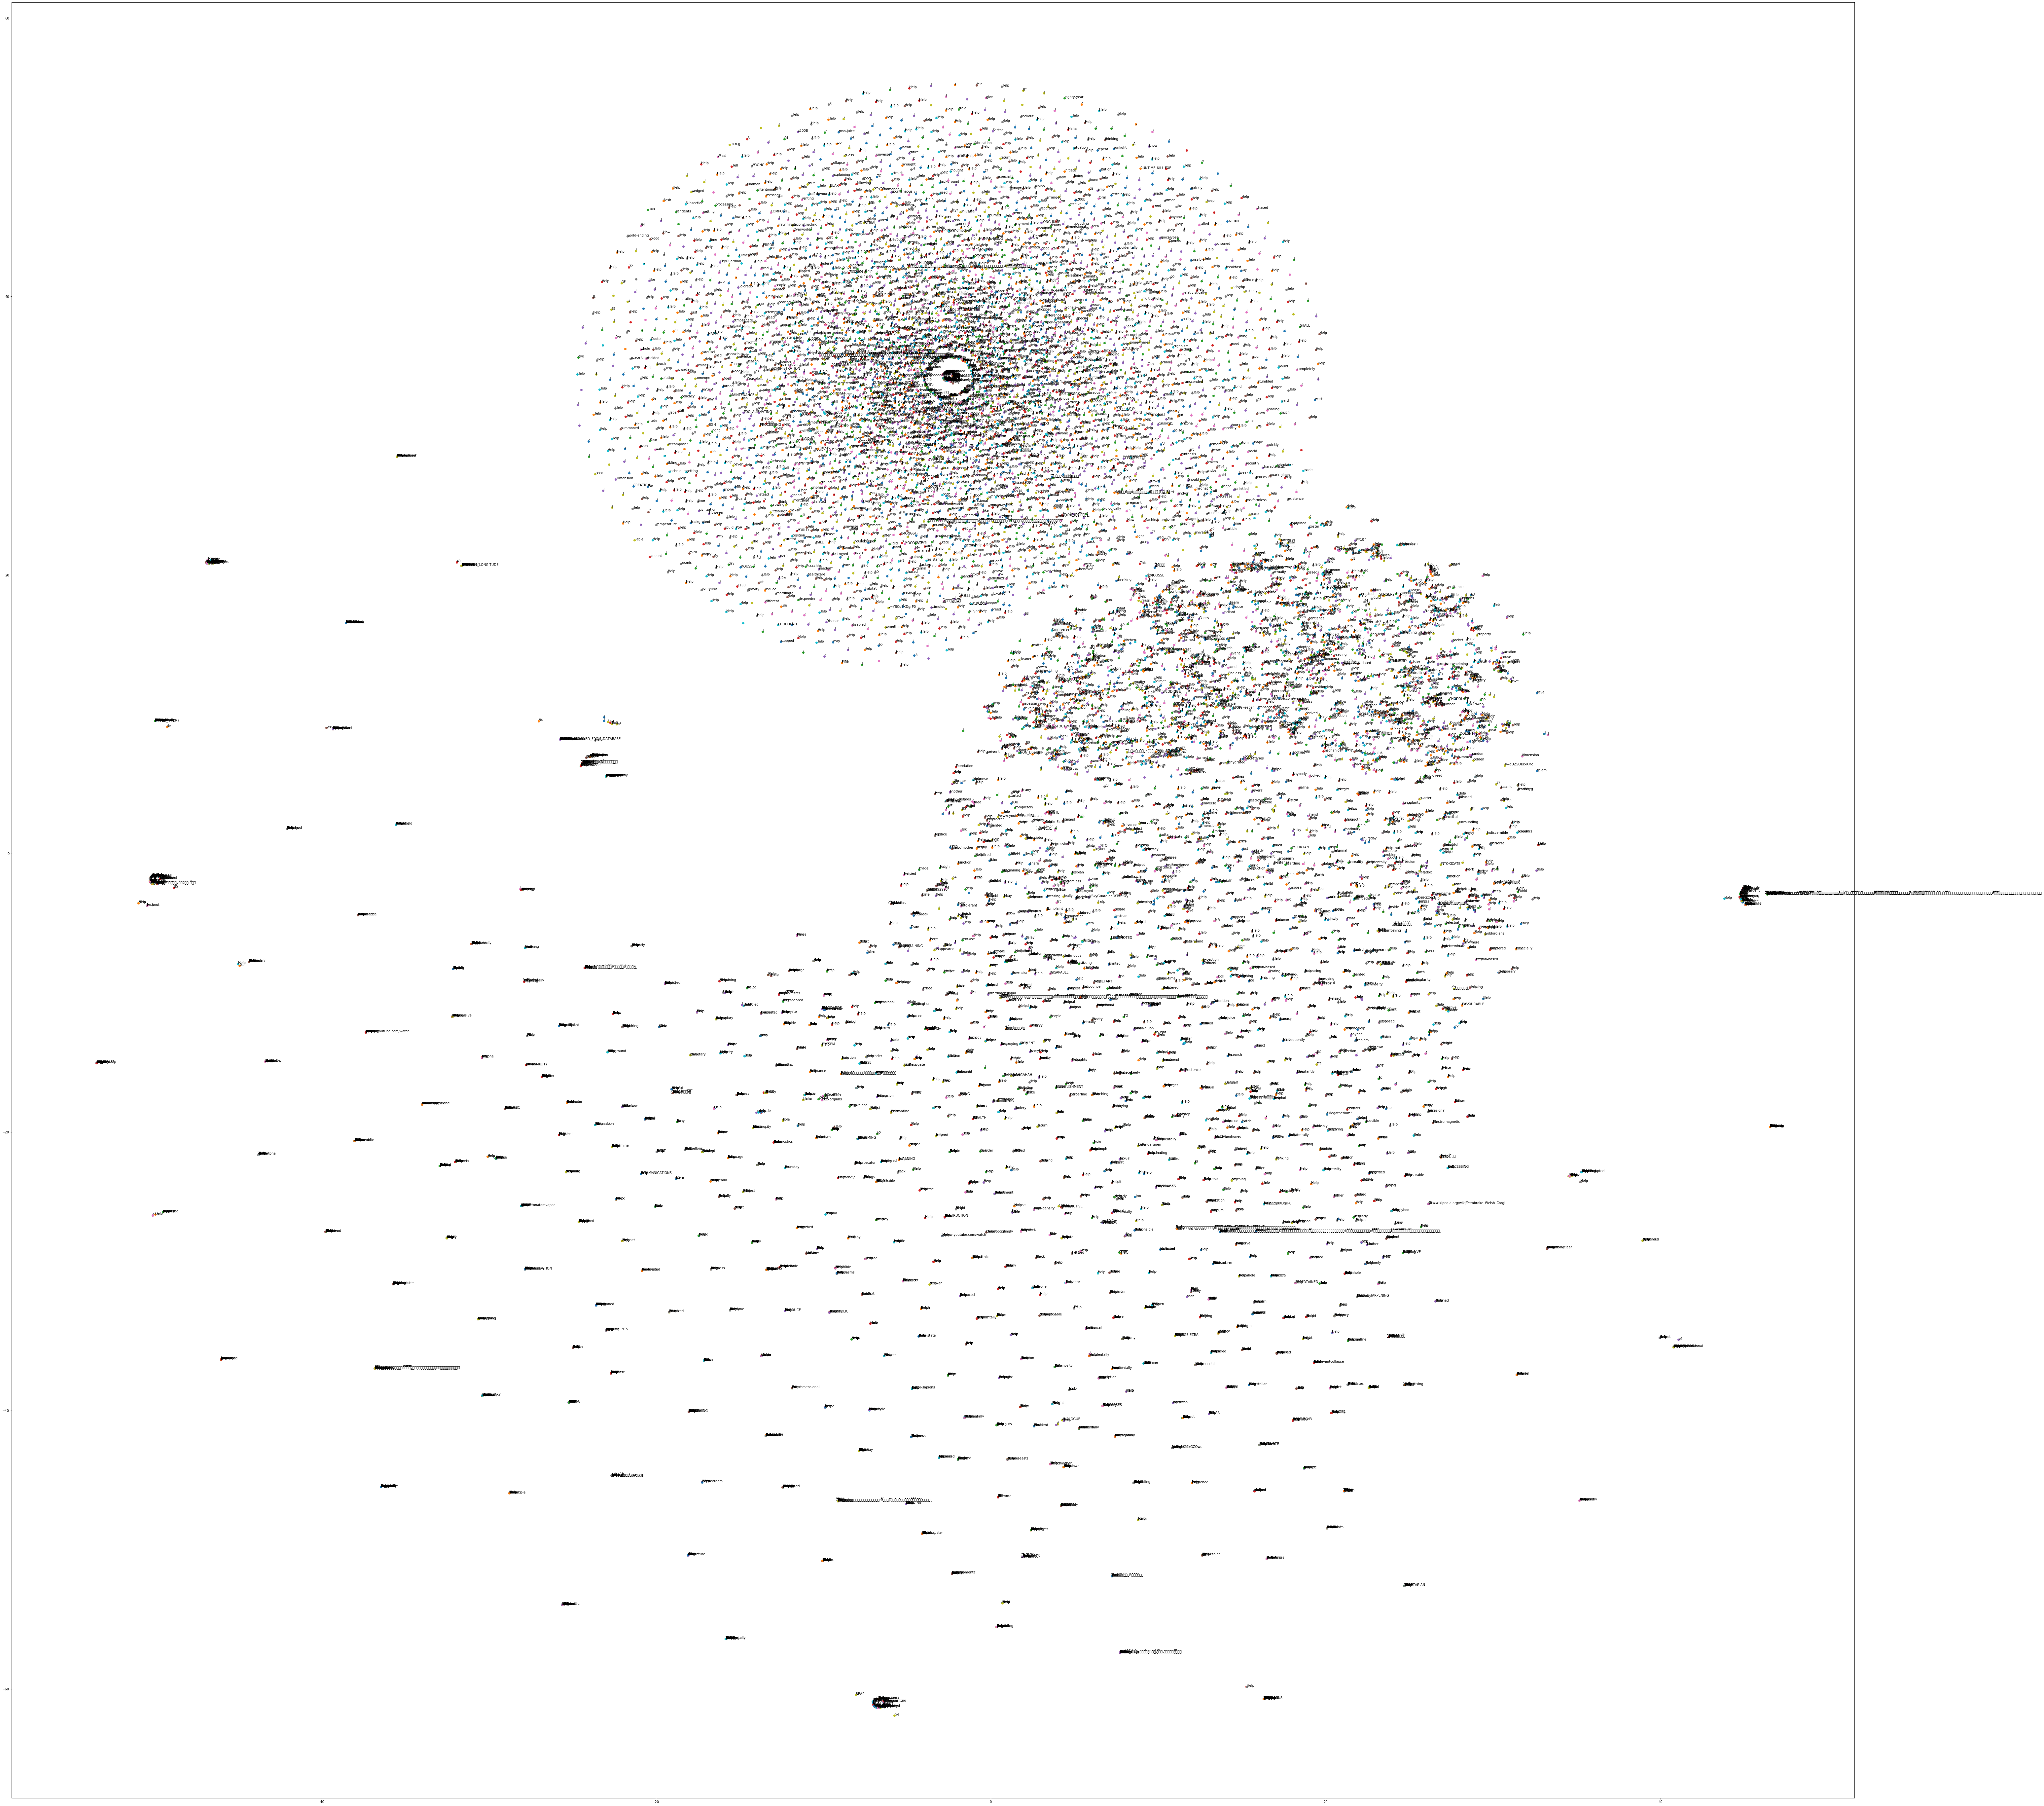

In [48]:
# supressing warnings for this cell only because they are font warnings
# WARNING this cell takes a very long to run
# Plotting t-sne visualization with labels

warnings.filterwarnings('ignore')

plt.figure(figsize=(100,100))
# color=plt.cm.Set1(np.log10(abs(z[:,0])))
labels = X[0]

for i in range(len(w[:,0])):

    plt.scatter(w[i,0], w[i,1]);
    plt.annotate(s=f'{labels[i]}', xy=(w[i,0],w[i,1]))


In [49]:
# restoring warnings 
warnings.filterwarnings('default')


In [50]:
# untokenizing text
main['all_text'] = [' '.join(val) for val in main['all_text']]

In [51]:
main['all_text']

0       Please help ! This coded message keep appearin...
1       Help : I accidentally changed `` dime dozen ''...
2       My universal remote controller n't controlling...
3       Accidentally programmed universe rain nuke eve...
4       Help I accidentally The Thing . I accidentally...
                              ...                        
4609    My wife us shared calendar personal reminder G...
4610    Ca n't find car key car still start Ca n't fin...
4611    𝕴 𝖉𝖎𝖘𝖈𝖔𝖛𝖊𝖗𝖊𝖉 𝖘𝖔𝖒𝖊 𝖓𝖊𝖜 𝖋𝖔𝖓𝖙𝖘 𝔹𝕦𝕥 𝕕𝕠𝕟 ' 𝕥 𝕜𝕟𝕠𝕨 𝕨...
4612    Not Do ever go gargle mayonnaise pick wrong ja...
4613    I ca n't read funny factoid Tropico 5 loading ...
Name: all_text, Length: 4614, dtype: object

In [52]:
# outputing clean results
main.to_csv('data/results.csv', index=False)